<a href="https://colab.research.google.com/github/kffaisal/LCMS/blob/main/Dynamic_Baseline_BHK_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\# **Dynamic Baseline of PT. BHK ARR - NDVI**

### Load Project Plots and Candidate of Control Plots Shapefiles

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import subprocess

# Run pip install silently
subprocess.run(["pip", "install", "contextily"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("Contextily installation finished.")


Contextily installation finished.


In [4]:
# Import required libraries
import geopandas as gpd
import matplotlib.pyplot as plt

In [5]:
# Define the file paths (adjust if necessary)
project_plots_path = '/content/drive/MyDrive/DB_BHK/Spatial/plots_project.shp'
control_plots_candidate_path = '/content/drive/MyDrive/DB_BHK/Spatial/plots_control_candidates.shp'
project_area_path = '/content/drive/MyDrive/DB_BHK/Spatial/BHK_12.shp'
# Load the shapefiles using GeoPandas
project_plots = gpd.read_file(project_plots_path)
control_plots_candidate = gpd.read_file(control_plots_candidate_path)
project_area = gpd.read_file(project_area_path)

Display the map

/tmp/ipython-input-6-709363662.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


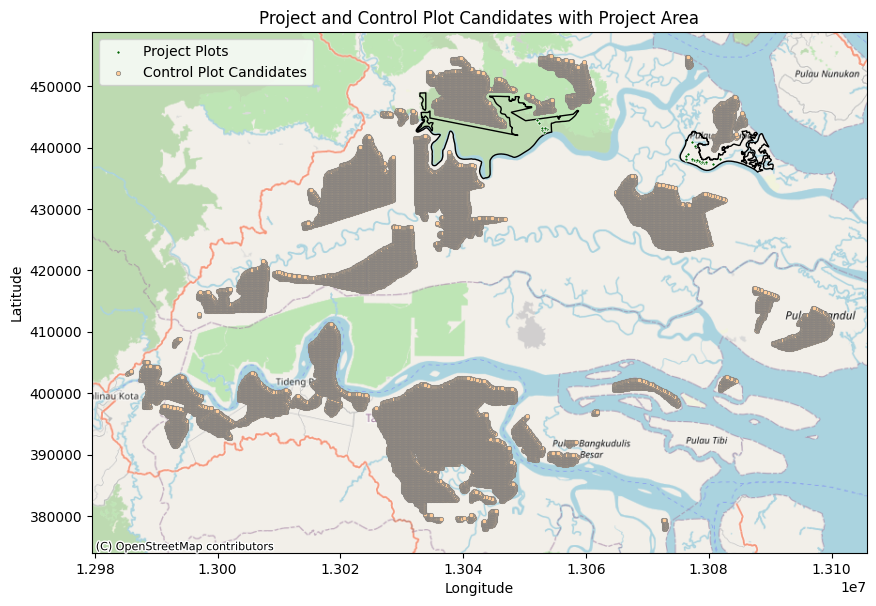

In [6]:
import contextily as ctx

# Reproject the GeoDataFrames to Web Mercator (EPSG:3857)
project_area_3857 = project_area.to_crs(epsg=3857)
project_plots_3857 = project_plots.to_crs(epsg=3857)
control_plots_candidate_3857 = control_plots_candidate.to_crs(epsg=3857)

# Create a map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Project Area polygon (outline only)
project_area_3857.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Project Area')

# Plot project plots in dark green
project_plots_3857.plot(
    ax=ax,
    color='darkgreen',
    edgecolor='white',
    markersize=5,
    linewidth=0.5,
    label='Project Plots'
)

# Plot candidate control plots in light orange
control_plots_candidate_3857.plot(
    ax=ax,
    color='#FFCC99',
    edgecolor='grey',
    markersize=10,
    linewidth=0.5,
    label='Control Plot Candidates'
)

# Add the OSM basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.legend()
plt.title('Project and Control Plot Candidates with Project Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



Explore The Attribute Tables

In [7]:
# Explore attribute table for project_plots

print("=== Project Plots Attribute Table ===")
# Display the first 5 rows of the attribute table
print(project_plots.head())

print("\nProject Plots Columns:")
print(project_plots.columns)

print("\nProject Plots Info:")
project_plots.info()

# Explore attribute table for control_plots_candidate

print("\n=== Control Plots Candidate Attribute Table ===")
# Display the first 5 rows of the attribute table
print(control_plots_candidate.head())

print("\nControl Plots Candidate Columns:")
print(control_plots_candidate.columns)

print("\nControl Plots Candidate Info:")
control_plots_candidate.info()

# calculate number of control plots candidates
num_rows = len(control_plots_candidate)
print(f"Number of control candidates points: {num_rows}")

=== Project Plots Attribute Table ===
   Shape_Leng  Shape_Area GRID_ID  ORIG_FID  RVI_2015  RVI_2016  RVI_2017  \
0     0.00406    0.000001   PF-85      9350  0.783839  0.886266  0.820477   
1     0.00406    0.000001   ON-84      9828  0.714330  0.867904  0.807724   
2     0.00406    0.000001   OR-84      9832  0.834440  0.822797  0.884216   
3     0.00406    0.000001   OU-84      9835  0.822738  0.794215  0.804514   
4     0.00406    0.000001   OO-83     10325  0.762370  0.818743  0.818305   

   RVI_2018  RVI_2019  RVI_2020  ...  NDVI_2023  NDVI_2024  AGB15  AGB16  \
0  0.751618  0.765165  0.665138  ...   0.774279   0.752541     48     22   
1  0.749492  0.717251  0.734260  ...   0.890734   0.860728    129     72   
2  0.752057  0.735897  0.699732  ...   0.838149   0.797259    203     33   
3  0.821890  0.749506  0.754245  ...   0.840217   0.798566     51    177   
4  0.847139  0.677097  0.754270  ...   0.893382   0.845824     19     19   

   AGB17  AGB18  AGB19  AGB20  AGB21      

### Select Control Plots
To match candidate control plots with project plots, apply a k-nearest neighbor optimal matching approach without replacement (i.e., control plots may not be matched to multiple project sample plots). The number of control plots matched to each project plot, k, is selected by the project proponent. k must be kept constant for each match (e.g., if k=5 for project plot A, k must remain 5 for the project lifetime).
Select the k control plots with the lowest multivariate distance metric values and derive relative
weights proportional to the inverse of the multivariate distance metric value, that sum to 1

$W_{\text{control},i,j} = \dfrac{e^{-MD_{i,j}}}{\sum_{j=1}^{n_{i,j}} e^{-MD_{i,j}}}$


Where:  
$W_{\text{control},i,j}$ = Weight of control plot $j$ matched to project plot $i$ (value between 0 and 1; dimensionless)  
$MD_{i,j}$ = Multivariate distance of control plot $j$ relative to project plot $i$ (dimensionless)  
$n_{i,j}$ = Number of control plots matched to project plot $i$ (equal to $k$ at project start date)


In [8]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# Define the number of control plots to match per project plot
k = 5  # Change this as needed

# Define the covariate columns (adjust if your column names differ)
covariates = ['NDVI_2015', 'NDVI_2017', 'NDVI_2024']

# Extract the covariate arrays from the GeoDataFrames.
# Ensure that these columns exist and are numeric in both project_plots and control_plots_candidate.
project_cov = project_plots[covariates].values  # shape: (n_project, 3)
control_cov = control_plots_candidate[covariates].values  # shape: (n_control, 3)

n_project = project_cov.shape[0]
n_control = control_cov.shape[0]

# Check that there are enough control plots for matching without replacement.
if n_project * k > n_control:
    raise ValueError("Not enough control plots to assign k matches to each project plot without replacement.")

# Replicate each project plot k times to prepare for the assignment problem.
# This creates an array of shape (n_project*k, 3)
project_cov_repeated = np.repeat(project_cov, k, axis=0)

# Compute the Euclidean distance (MD) between each replicated project plot and each control plot.
# The resulting cost_matrix has shape (n_project*k, n_control)
cost_matrix = np.sqrt(((project_cov_repeated[:, None, :] - control_cov[None, :, :]) ** 2).sum(axis=2))

# Solve the assignment problem using the Hungarian algorithm.
# This returns indices for the optimal assignment of each replicated project row to a unique control plot.
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Collect assignments: map each project plot index to its assigned control plots and distances.
# (Since we replicated each project k times, the project index is obtained by integer-dividing the row index by k.)
assignments = {i: [] for i in range(n_project)}
for r, c in zip(row_ind, col_ind):
    project_index = r // k
    distance = cost_matrix[r, c]
    assignments[project_index].append((c, distance))

# For each project plot, sort its matches by distance (lowest first) and take exactly k matches.
# Then compute weights using the provided exponential formula.
final_assignments = {}
final_weights = {}
for proj_idx, matches in assignments.items():
    # In principle, each project plot should have exactly k matches.
    sorted_matches = sorted(matches, key=lambda x: x[1])
    selected = sorted_matches[:k]
    final_assignments[proj_idx] = selected

    # Compute weights: weight = exp(-distance) normalized to sum to 1 for the k matches.
    distances = np.array([d for (_, d) in selected])
    exp_neg_dist = np.exp(-distances)
    weights = exp_neg_dist / exp_neg_dist.sum()
    # Store as a list of tuples: (control_index, weight)
    final_weights[proj_idx] = list(zip([m[0] for m in selected], weights))

# Display the matching results for each project plot.
for proj_idx, matches in final_assignments.items():
    print(f"Project Plot {proj_idx}:")
    for control_idx, distance in matches:
        # Retrieve the corresponding weight
        weight = [w for (ci, w) in final_weights[proj_idx] if ci == control_idx][0]
        print(f"  Matched Control Plot {control_idx}: Distance = {distance:.4f}, Weight = {weight:.4f}")
    print()


Project Plot 0:
  Matched Control Plot 14549: Distance = 0.0035, Weight = 0.2005
  Matched Control Plot 18545: Distance = 0.0048, Weight = 0.2003
  Matched Control Plot 15228: Distance = 0.0069, Weight = 0.1998
  Matched Control Plot 15948: Distance = 0.0072, Weight = 0.1998
  Matched Control Plot 16307: Distance = 0.0081, Weight = 0.1996

Project Plot 1:
  Matched Control Plot 46389: Distance = 0.0044, Weight = 0.2003
  Matched Control Plot 46554: Distance = 0.0054, Weight = 0.2001
  Matched Control Plot 95969: Distance = 0.0059, Weight = 0.2000
  Matched Control Plot 44409: Distance = 0.0068, Weight = 0.1998
  Matched Control Plot 63159: Distance = 0.0070, Weight = 0.1998

Project Plot 2:
  Matched Control Plot 83559: Distance = 0.0067, Weight = 0.2003
  Matched Control Plot 69188: Distance = 0.0077, Weight = 0.2001
  Matched Control Plot 74973: Distance = 0.0079, Weight = 0.2001
  Matched Control Plot 6922: Distance = 0.0094, Weight = 0.1998
  Matched Control Plot 47822: Distance = 

### Evaluate match quality and finalize matching
For the sample population of matched pairs ( project plots and matched sets of control plots),
evaluate match quality and finalize matching.
For each included matching covariate x, calculate the standardized difference of means (SDM)
as:
The formula in the image can be written as:  

$SDM = \dfrac{ \left| \bar{x}_{wp,x} - \bar{x}_{bsl,x} \right| }{ \sqrt{ \dfrac{ \sigma^2_{wp,x} + \sigma^2_{bsl,x} }{2} } }$


Where:  
$SDM$ = Standardized difference of means  
$\bar{x}_{wp,x}$ = Mean value of covariate $x$ in the population of project plots  
$\bar{x}_{bsl,x}$ = Mean value of weighted sums of covariate $x$ in the population of matched sets of control plots  
$\sigma^2_{wp,x}$ = Variance of covariate $x$ in the population of project plots  
$\sigma^2_{bsl,x}$ = Variance of covariate $x$ in the population of control plots  





Overall match results are deemed valid where SDM for each covariate is less than or equal to 0.25. Where the overall match is deemed valid, the final selection of control plots and their respective weights are then fixed, and UTM coordinates recorded, for the duration of the crediting
period. Where the overall match is not deemed valid, Steps 1, 2, and 3 are repeated after:

a) Progressively expanding the radius of the donor pool in 100 km increments, and/or

b) Decreasing the k value for all project plots, until a valid overall match is achieved.


In [9]:
import numpy as np

# Define the covariate columns (should match those used in matching)
covariates = ['NDVI_2015', 'NDVI_2017', 'NDVI_2024']

# Initialize a dictionary to store SDM values for each covariate
sdm_results = {}

# For each covariate, calculate SDM as:
# SDM = |mean_project - mean_weighted_control| / sqrt( (var_project + var_weighted_control)/2 )
for cov in covariates:
    # Get covariate values for project plots (ensure they are floats)
    project_values = project_plots[cov].astype(float).values
    mean_project = np.mean(project_values)
    var_project = np.var(project_values, ddof=1)

    # For each project plot, compute the weighted covariate value from its matched control plots
    weighted_control_values = []
    for i in range(project_values.shape[0]):
        # Retrieve the list of (control_index, weight) tuples for project plot i
        # (final_weights dictionary computed in the matching cell)
        weights_for_i = final_weights[i]  # Each element is (control_index, weight)
        # Compute the weighted value for the covariate from matched control plots
        weighted_val = sum(weight * control_plots_candidate.iloc[control_idx][cov]
                           for control_idx, weight in weights_for_i)
        weighted_control_values.append(weighted_val)

    weighted_control_values = np.array(weighted_control_values, dtype=float)
    mean_control = np.mean(weighted_control_values)
    var_control = np.var(weighted_control_values, ddof=1)

    # Compute the SDM for this covariate
    sdm = abs(mean_project - mean_control) / np.sqrt((var_project + var_control) / 2)
    sdm_results[cov] = sdm

# Display the SDM results for each covariate
print("Standardized Difference of Means (SDM) for each covariate:")
for cov, sdm in sdm_results.items():
    validity = "Valid (SDM <= 0.25)" if sdm <= 0.25 else "Not valid (SDM > 0.25)"
    print(f"Covariate {cov}: SDM = {sdm:.4f} ({validity})")

# Overall match validity: valid if all SDMs are <= 0.25
if all(sdm <= 0.25 for sdm in sdm_results.values()):
    print("\nOverall match is valid. Final control plot selection and weights are fixed for the duration of the crediting period.")
else:
    print("\nOverall match is not valid. Consider expanding the donor pool radius (in 100 km increments) and/or decreasing the k value for all project plots, then repeat matching.")


Standardized Difference of Means (SDM) for each covariate:
Covariate NDVI_2015: SDM = 0.0072 (Valid (SDM <= 0.25))
Covariate NDVI_2017: SDM = 0.0021 (Valid (SDM <= 0.25))
Covariate NDVI_2024: SDM = 0.0088 (Valid (SDM <= 0.25))

Overall match is valid. Final control plot selection and weights are fixed for the duration of the crediting period.


Extract the selected control plots from the matching results

In [10]:
# Extract unique indices of selected control plots from the matching results
selected_control_indices = set()
for proj_idx, matches in final_assignments.items():
    for control_idx, _ in matches:
        selected_control_indices.add(control_idx)

# Subset the control_plots_candidate GeoDataFrame to only include the selected control plots
selected_control_plots = control_plots_candidate.iloc[list(selected_control_indices)]

### Display The Result

/tmp/ipython-input-11-3309775843.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


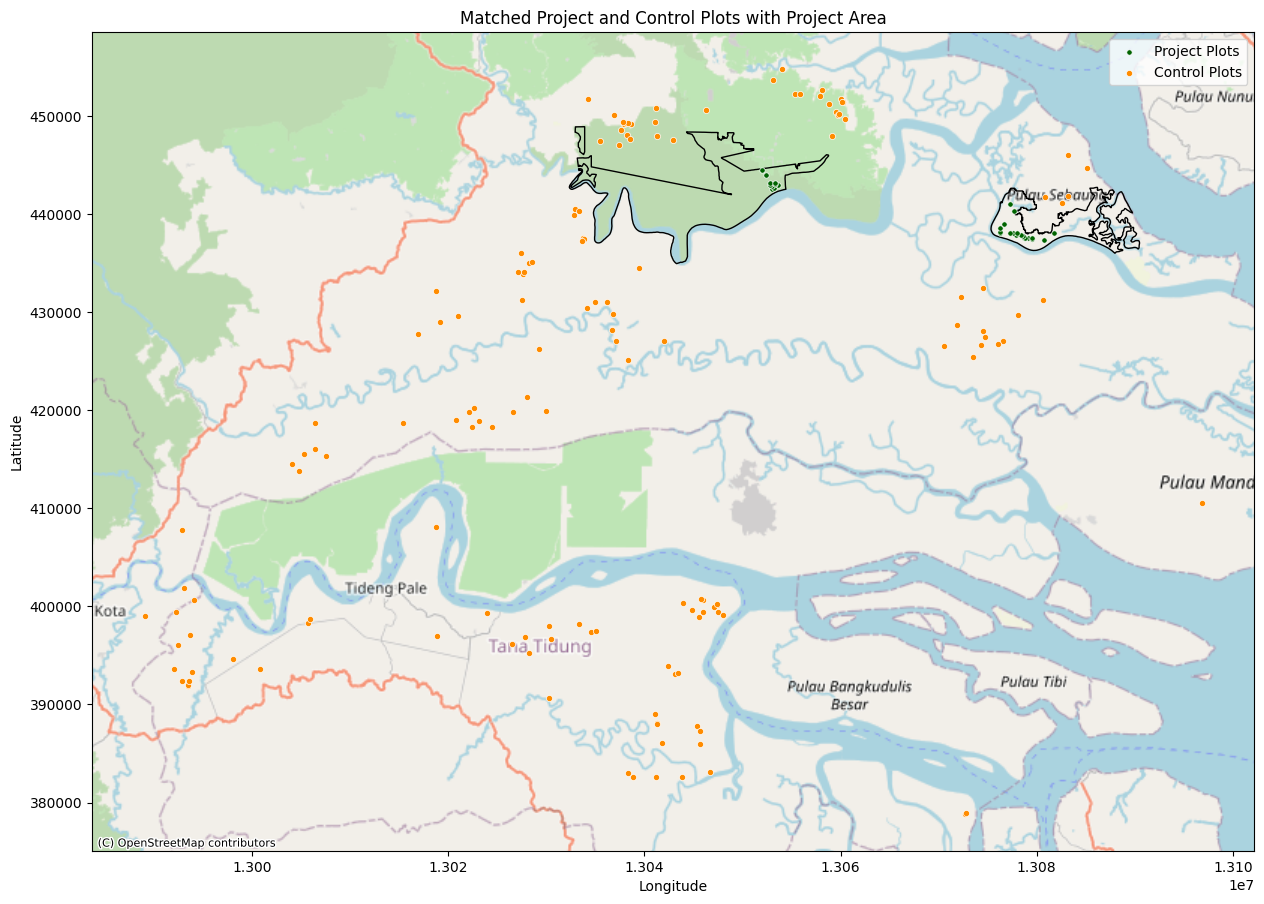

In [11]:
import contextily as ctx

# Reproject the GeoDataFrames to Web Mercator (EPSG:3857)
project_area_3857 = project_area.to_crs(epsg=3857)
project_plots_3857 = project_plots.to_crs(epsg=3857)
selected_control_plots_3857 = selected_control_plots.to_crs(epsg=3857)

# Create a map
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the Project Area polygon (outline only)
project_area_3857.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Project Area')

# Plot project plots in dark green
project_plots_3857.plot(
    ax=ax,
    color='darkgreen',
    edgecolor='white',
    markersize=15,
    linewidth=0.5,
    label='Project Plots'
)

# Plot selected control plots in light orange
selected_control_plots_3857.plot(
    ax=ax,
    color='#FF8C00',
    edgecolor='white',
    markersize=20,
    linewidth=0.5,
    label='Control Plots'
)

# Add the OSM basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.legend()
plt.title('Matched Project and Control Plots with Project Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [12]:
# Count the number of unique selected control plots
num_selected_control_plots = len(selected_control_indices)
print(f"Number of selected control plots: {num_selected_control_plots}")


Number of selected control plots: 150


In [13]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Now simply display the DataFrame
display(selected_control_plots)


,Shape_Leng,Shape_Area,GRID_ID,ORIG_FID,RVI_2015,RVI_2016,RVI_2017,RVI_2018,RVI_2019,RVI_2020,...,NDVI_2016,NDVI_2017,NDVI_2018,NDVI_2019,NDVI_2020,NDVI_2021,NDVI_2022,NDVI_2023,NDVI_2024,geometry
83461,0.003492,8.800083e-07,UF-53,753027,0.884014,0.910028,0.990168,0.672810,0.745849,0.792552,...,0.866515,0.894636,0.468507,0.851649,0.872328,0.888202,0.869738,0.493425,0.717584,POINT (117.1278 4.03206)
84997,0.003492,8.800071e-07,ACM-42,766277,0.603365,0.547285,0.633400,0.639760,0.538442,0.574847,...,0.806983,0.800521,0.792679,0.823265,0.798718,0.811257,0.768913,0.798440,0.794296,POINT (117.31549 4.04265)
1031,0.003492,8.800088e-07,EE-538,177885,0.797777,0.818063,0.810848,0.790753,0.816526,0.802238,...,0.880701,0.904305,0.866103,0.874125,0.880496,0.846232,0.866837,0.885185,0.875721,POINT (116.76376 3.54266)
82442,0.003492,8.800080e-07,UB-63,741173,0.916577,0.964182,0.962043,0.819781,0.967027,0.895509,...,0.880824,0.913453,0.880365,0.896691,0.884205,0.896509,0.880066,0.886034,0.851648,POINT (117.1243 4.02198)
87051,0.003492,8.800083e-07,AAV-26,785194,0.604112,0.552995,0.567577,0.488452,0.555997,0.484068,...,0.784244,0.802098,0.821153,0.820638,0.802679,0.824987,0.827229,0.823989,0.795839,POINT (117.27795 4.05928)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78321,0.003492,8.800088e-07,SD-132,659358,0.814146,0.954785,0.975149,0.792296,0.800720,0.800683,...,0.889476,0.915335,0.895485,0.906323,0.895802,0.913025,0.871536,0.897433,0.870394,POINT (117.08065 3.95243)
92146,0.003492,8.800088e-07,AIL-241,530617,0.828214,0.861310,0.945519,0.815041,0.794614,0.952723,...,0.886006,0.900307,0.824549,0.883513,0.889892,0.862438,0.833077,0.805265,0.749711,POINT (117.4508 3.84255)
44027,0.003492,8.800080e-07,XY-498,225799,0.655982,0.642931,0.715982,0.699844,0.613936,0.636750,...,0.818830,0.844866,0.821086,0.833050,0.852430,0.837396,0.749533,0.815014,0.830225,POINT (117.21248 3.58298)
85500,0.003492,8.800080e-07,VG-38,770829,0.851976,0.884183,0.840175,0.887242,0.741693,0.824558,...,0.846757,0.880518,0.852475,0.871667,0.852949,0.873765,0.841672,0.876041,0.823248,POINT (117.15137 4.04668)


### Export the (selected) Control Plots

In [14]:
# Define the output path (same folder as your inputs)
output_path = '/content/drive/MyDrive/DB_BHK/Spatial/plots_control_ndvi.shp'

# Export the selected control plots to a shapefile
selected_control_plots.to_file(output_path)

print(f"Selected control plots have been saved to: {output_path}")


Selected control plots have been saved to: /content/drive/MyDrive/DB_BHK/Spatial/plots_control_ndvi.shp
